In [1]:
%run geometria.ipynb

In [2]:
Tolerance = 10e-12

# Funkcje pomocnicze

In [3]:
def det(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + a[1] * c[0] - c[0] * b[1] - b[0] * a[1] - a[0] * c[1]

def orient(a, b, c):
    determinant = det(a, b, c)
    if determinant > Tolerance: # lewa strona
        return 1
    elif determinant < -Tolerance: # prawa strona
        return -1
    else: # współliniowe
        return 0
    
def trivial(points, first, last): # Wyznaczanie otoczki dla <= 3 punktów.
    if last - first < 0:
        return []
    if last - first == 0:
        return [points[first]]
    if last - first == 1:
        if points[first] == points[last]:
            return [points[first]]
        return [points[first], points[last]]
    if last - first == 2:
        if orient(points[first], points[first+1], points[first+2]) == 1:
            return [points[first], points[first+1], points[first+2]]
        elif (points[first][0] ==  points[first+1][0] and orient(points[first], points[first+1], points[first+2]) != 0) or orient(points[first], points[first + 1], points[first + 2]) == -1:
            return [points[first], points[first+2], points[first+1]]
        else:
            return [points[first], points[first+2]]

        
def find_max_x(hull): # Wyznaczanie indeksu punktu otoczki o największej wartości zmiennej x.
    n = len(hull)
    max_x = -float("inf")
    max_x_index = -1
    for i in range(n):
        if hull[i][0] > max_x:
            max_x = hull[i][0]
            max_x_index = i
    
    return max_x_index

def find_min_x(hull): # Wyznaczanie indeksu punktu otoczki o najmniejszej wartości zmiennej x.
    n = len(hull)
    n = len(hull)
    min_x = float("inf")
    min_x_index = -1
    for i in range(n):
        if hull[i][0] < min_x:
            min_x = hull[i][0]
            min_x_index = i
    
    return min_x_index
          

# Główny algorytm

In [4]:
def merger(hull1, hull2): # Funkcja łącząca otoczki sąsiadujących zbiorów.
    global hulls, scenes

    new_hull = []
    n1 = len(hull1)
    n2 = len(hull2)

    max_x_index = find_max_x(hull1)
    min_x_index = find_min_x(hull2)
    
    # Wyznaczanie górnej stycznej otoczek.
    index1 = max_x_index
    index2 = min_x_index
    flag = False
    while not flag:
        flag = True
        while orient(hull1[index1 % n1], hull1[(index1 + 1) % n1], hull2[index2 % n2]) <= 0:
            index1 = (index1 + 1) % n1

        while orient(hull1[index1 % n1], hull2[(index2 + n2 - 1) % n2], hull2[index2 % n2]) <= 0:
            index2 = (index2 + n2 - 1) % n2
            flag = False
    upper1, upper2 = index1, index2
    
    # Wyznaczanie dolnej stycznej otoczek.
    index1 = max_x_index
    index2 = min_x_index
    flag = False
    while not flag:
        flag = True
        while orient(hull1[(index1 + n1 - 1) % n1], hull1[index1 % n1], hull2[index2 % n2]) <= 0:
            index1 = (index1 + n1 - 1) % n1

        while orient(hull1[index1 % n1], hull2[index2 % n2], hull2[(index2 + 1) % n2]) <= 0:
            index2 = (index2 + 1) % n2
            flag = False

    lower1, lower2 = index1, index2

    
    lines = []
    points_scene = []
    for hull in hulls:
        n = len(hull)
        for i in range(n):
            lines.append([hull[i], hull[(i + 1) % n]])
            points_scene.append(hull[i])
    scenes.append(Scene([PointsCollection(data, color='hotpink'),
                         PointsCollection(points_scene, color='green')],
                        [LinesCollection(deepcopy(lines), color='lime'),
                         LinesCollection([(hull1[upper1], hull2[upper2]), (hull1[lower1], hull2[lower2])],
                                         color='forestgreen')]))
    
    hulls.remove(hull1)
    hulls.remove(hull2)
    
    # Sklejanie otoczek
    new_hull.append(hull1[lower1])
    new_hull.append(hull2[lower2])
    if lower2 != upper2:
        index1 = lower2 + 1
        while index1 % n2 != upper2:
            new_hull.append(hull2[index1 % n2])
            index1 += 1
        new_hull.append(hull2[upper2])

    if upper1 != lower1:
        new_hull.append(hull1[upper1])
        index2 = upper1 + 1
        while index2 % n1 != lower1:
            new_hull.append(hull1[index2 % n1])
            index2 += 1

    return new_hull


def divide(points, first, last): # Funkcja rekurencyjna dzieląca zbiór, na mniejsze podzbiory.
    global hulls, scenes
    if last - first < 3:
        hull = trivial(points, first, last)
        hulls.append(hull)
        lines = []
        points_scene = []
        for hull in hulls:
            n = len(hull)
            for i in range(n):
                lines.append([hull[i], hull[(i + 1) % n]])
                points_scene.append(hull[i])
        scenes.append(Scene([PointsCollection(data, color='hotpink'),
                             PointsCollection(points_scene, color='green')],
                            [LinesCollection(deepcopy(lines), color='lime')]))

        return hull

    mid = (last + first) // 2

    hull1 = divide(points, first, mid)
    hull2 = divide(points, mid + 1, last)

    if len(hull1) == 0:
        hulls.remove(hull1)
        return hull2
    if len(hull2) == 0:
        hulls.remove(hull2)
        return hull1

    hull = merger(hull1, hull2)
    hulls.append(hull)

    lines = []
    points_scene = []
    for hull in hulls:
        n = len(hull)
        for i in range(n):
            lines.append([hull[i], hull[(i + 1) % n]])
            points_scene.append(hull[i])
    scenes.append(Scene([PointsCollection(data, color='hotpink'),
                         PointsCollection(points_scene, color='green')],
                        [LinesCollection(deepcopy(lines), color='lime')]))

    return hull


def convex_hull(points):
    global scenes
    scenes.append(Scene([PointsCollection(data, color='hotpink')]))
    
    # Punkty zostają posortowane.
    sorted_points = sorted(points, key=lambda p: (p[0], p[1]))

    # Z postortowanego zbioru usuwane są punkty o takiej samej współrzędnej x, z pominięciem tych punktów, 
    # które dla tego samego x mają najmneijszą i największą wartość y.
    new_points = []
    new_points.append(sorted_points[0])
    last_x = sorted_points[0][0]
    i = 1
    while i < len(sorted_points):
        if sorted_points[i][0] != last_x:
            new_points.append(sorted_points[i])
            last_x = sorted_points[i][0]
        else:
            while i < len(sorted_points) and sorted_points[i][0] == last_x:
                i += 1
            i -= 1
            new_points.append(sorted_points[i])
            last_x = sorted_points[i][0]
        i += 1
    n = len(new_points)
    
    hull = divide(new_points, 0, n - 1)
    return hull


# Testowanie

Liczba punktów otoczki:  11
Punkty otoczki:  [(33.37168852939855, 4.331854433200844), (47.52381089293291, 4.171120677417173), (97.91399051859196, 5.406172685330802), (98.39929136910351, 12.02993547084411), (98.74664213024184, 69.5247460725637), (80.5210681705032, 87.72844236874998), (53.99302235778595, 94.82228711767473), (34.73921930783979, 99.89407724832414), (16.264772005025975, 98.3386186924478), (1.3934673379454865, 96.07716195407052), (3.67055564008677, 7.2030063772307695)]


<IPython.core.display.Javascript object>


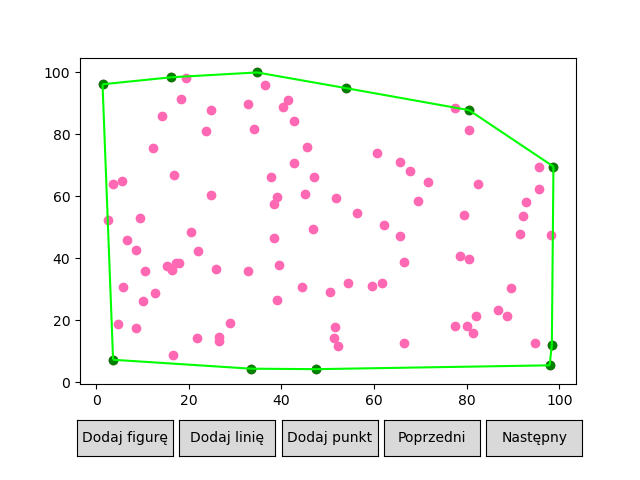

In [5]:
def generate_points(amount, low, high):
    a = np.random.rand(amount).astype(np.float64) * (high - low) + low
    b = np.random.rand(amount).astype(np.float64) * (high - low) + low
    return list(zip(a, b))

hulls = []
scenes = []
data = generate_points(100, 0, 100)
hull = convex_hull(data)
print("Liczba punktów otoczki: ", len(hull))
print("Punkty otoczki: ", hull)
plot = Plot(scenes=scenes)
plot.draw()

Liczba punktów otoczki:  4
Punkty otoczki:  [(0, 0), (3, 0), (3, 3), (0, 3)]


<IPython.core.display.Javascript object>


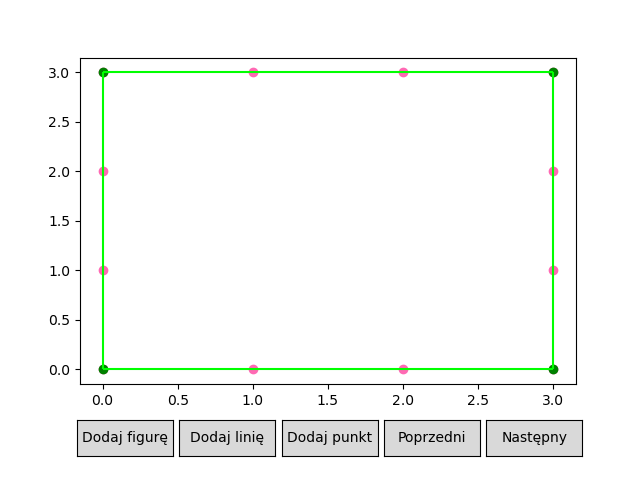

In [6]:
data = [(0,0),(1,0),(2,0),(3,0),(0,1),(0,2),(0,3),(3,3),(3,1),(3,2),(1,3),(2,3)]
hulls = []
scenes = []
hull = convex_hull(data)
print("Liczba punktów otoczki: ", len(hull))
print("Punkty otoczki: ", hull)
plot = Plot(scenes=scenes)
plot.draw()

Liczba punktów otoczki:  6
Punkty otoczki:  [(1, 0), (2, 0), (3, 1), (2, 2), (1, 2), (0, 1)]


<IPython.core.display.Javascript object>


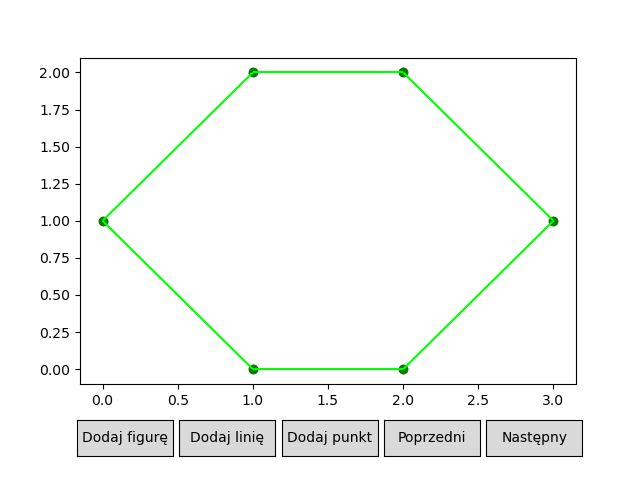

In [7]:
data = [(0,1), (1,2), (1, 0), (2,2), (2,0), (3,1)]
hulls = []
scenes = []
hull = convex_hull(data)
print("Liczba punktów otoczki: ", len(hull))
print("Punkty otoczki: ", hull)
plot = Plot(scenes=scenes)
plot.draw()

# Algorytm bez wizualizacji

In [8]:
def merger_(hull1, hull2): # Funkcja łącząca otoczki sąsiadujących zbiorów.
    global hulls

    new_hull = []
    n1 = len(hull1)
    n2 = len(hull2)

    max_x_index = find_max_x(hull1)
    min_x_index = find_min_x(hull2)
    
    # Wyznaczanie górnej stycznej otoczek.
    index1 = max_x_index
    index2 = min_x_index
    flag = False
    while not flag:
        flag = True
        while orient(hull1[index1 % n1], hull1[(index1 + 1) % n1], hull2[index2 % n2]) <= 0:
            index1 = (index1 + 1) % n1

        while orient(hull1[index1 % n1], hull2[(index2 + n2 - 1) % n2], hull2[index2 % n2]) <= 0:
            index2 = (index2 + n2 - 1) % n2
            flag = False
    upper1, upper2 = index1, index2
    
    # Wyznaczanie dolnej stycznej otoczek.
    index1 = max_x_index
    index2 = min_x_index
    flag = False
    while not flag:
        flag = True
        while orient(hull1[(index1 + n1 - 1) % n1], hull1[index1 % n1], hull2[index2 % n2]) <= 0:
            index1 = (index1 + n1 - 1) % n1

        while orient(hull1[index1 % n1], hull2[index2 % n2], hull2[(index2 + 1) % n2]) <= 0:
            index2 = (index2 + 1) % n2
            flag = False

    lower1, lower2 = index1, index2
    
    hulls.remove(hull1)
    hulls.remove(hull2)
    
    # Sklejanie otoczek
    new_hull.append(hull1[lower1])
    new_hull.append(hull2[lower2])
    if lower2 != upper2:
        index1 = lower2 + 1
        while index1 % n2 != upper2:
            new_hull.append(hull2[index1 % n2])
            index1 += 1
        new_hull.append(hull2[upper2])

    if upper1 != lower1:
        new_hull.append(hull1[upper1])
        index2 = upper1 + 1
        while index2 % n1 != lower1:
            new_hull.append(hull1[index2 % n1])
            index2 += 1

    return new_hull


def divide_(points, first, last): # Funkcja rekurencyjna dzieląca zbiór na mniejsze podzbiory.
    global hulls
    if last - first < 3:
        hull = trivial(points, first, last)
        hulls.append(hull)
        return hull

    mid = (last + first) // 2

    hull1 = divide(points, first, mid)
    hull2 = divide(points, mid + 1, last)

    if len(hull1) == 0:
        hulls.remove(hull1)
        return hull2
    if len(hull2) == 0:
        hulls.remove(hull2)
        return hull1

    hull = merger(hull1, hull2)
    hulls.append(hull)

    return hull


def convex_hull_(points):
    # Punkty zostają posortowane.
    sorted_points = sorted(points, key=lambda p: (p[0], p[1]))

    # Z postortowanego zbioru usuwane są punkty o takiej samej współrzędnej x, z pominięciem tych punktów, 
    # które dla tego samego x mają najmneijszą i największą wartość y.
    new_points = []
    new_points.append(sorted_points[0])
    last_x = sorted_points[0][0]
    i = 1
    while i < len(sorted_points):
        if sorted_points[i][0] != last_x:
            new_points.append(sorted_points[i])
            last_x = sorted_points[i][0]
        else:
            while i < len(sorted_points) and sorted_points[i][0] == last_x:
                i += 1
            i -= 1
            new_points.append(sorted_points[i])
            last_x = sorted_points[i][0]
        i += 1
    n = len(new_points)
    
    hull = divide(new_points, 0, n - 1)
    return hull